In [ ]:
!nvidia-smi

Tue Nov 26 17:44:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |    111MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import cv2
import numpy as np
import time

image_path = 'input_0.bmp'
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if input_image is None:
    raise ValueError("Изображение не загружено. Проверьте путь.")
else:
   print("Изображение загружено успешно.")

Изображение загружено успешно.


In [ ]:
# Алгоритм Харриса на CPU
def harris_corners_cpu(input_img, k, window_size, threshold):

    cpu_start_time = time.time()

    corner_list = []
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)

    offset = int(window_size / 2)  # Смещение для определения границ окна
    y_range = input_img.shape[0] - offset  # Диапазон по оси Y
    x_range = input_img.shape[1] - offset  # Диапазон по оси X

    # Вычисление градиентов по осям X и Y
    dy, dx = np.gradient(input_img)

    # Вычисление компонентов матрицы A
    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2

    for y in range(offset, y_range):
        for x in range(offset, x_range):

            # Определение границ окна для текущего пикселя
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            # Выборка значений окна для компонентов матрицы A
            windowIxx = Ixx[start_y:end_y, start_x:end_x]
            windowIxy = Ixy[start_y:end_y, start_x:end_x]
            windowIyy = Iyy[start_y:end_y, start_x:end_x]

            # Сумма квадратов интенсивностей градиентов
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            # Вычисление определителя и следа матрицы
            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy

            # Вычисление отклика Харриса
            r = det - k * (trace ** 2)

            if r > threshold:
                corner_list.append([x, y, r])
                cv2.circle(output_img, (x, y), 2, (255, 0, 0), -1)

    cpu_end_time = time.time()

    return output_img, cpu_end_time - cpu_start_time

In [ ]:
from numba import cuda, float32
import numba

@cuda.jit
def harris_corner_kernel(ixx, ixy, iyy, dest, k, threshold, offset, height, width):
    x, y = cuda.grid(2)
    if x >= offset and x < (width - offset) and y >= offset and y < (height - offset):
        sxx, sxy, syy = 0.0, 0.0, 0.0

        # Вычислите компоненты тензора структуры в окрестности
        for i in range(-offset, offset + 1):
            for j in range(-offset, offset + 1):
                sxx += ixx[y + j, x + i]
                sxy += ixy[y + j, x + i]
                syy += iyy[y + j, x + i]

        # Вычислить определитель и трассировку структурного тензора
        det = sxx * syy - sxy * sxy
        trace = sxx + syy
        r = det - k * (trace ** 2)

        if r > threshold:
            dest[y, x] = r

In [ ]:
def harris_corners_gpu(input_image, k, window_size, threshold):

    gpu_start_time = time.time()

    # Вычисление градиентов
    img = input_image.astype(np.float32)
    dy, dx = np.gradient(img)
    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2

    offset = int(window_size / 2)
    height, width = img.shape
    dest = np.zeros_like(img, dtype=np.float32)

    # Отправка данных на GPU
    d_ixx = cuda.to_device(Ixx)
    d_ixy = cuda.to_device(Ixy)
    d_iyy = cuda.to_device(Iyy)
    d_dest = cuda.to_device(dest)

    # Определим размеры
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Запускаем таймер
    start_time = time.time()

    # Запуск ядра
    harris_corner_kernel[blocks_per_grid, threads_per_block](d_ixx, d_ixy, d_iyy, d_dest,
                                                             k, threshold, offset,
                                                             height, width)
    # Копируем результат на хост
    dest = d_dest.copy_to_host()

    # Считаем время выполнения
    execution_time = time.time() - start_time

    # Извлекаем углы
    corners = np.argwhere(dest > threshold * dest.max())
    corner_list = [[x, y, dest[y, x]] for y, x in corners]

    # Преобразуем изображение в цветное
    img_color = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    for corner in corners:
        x, y = corner
        cv2.circle(img_color, (y, x), 2, (0, 0, 255), -1)

    gpu_end_time = time.time()

    return img_color, gpu_end_time - gpu_start_time

In [ ]:
k = 0.04  # Параметр k в уравнении Харриса
window_size = 3  # Размер окна для вычисления градиентов
threshold = 0.01  # Пороговое значение для определения угловых точек

output_image_gpu, time_gpu = harris_corners_gpu(input_image, k, window_size, threshold)
print(f"Время выполнения на GPU: {time_gpu:.4f} сек")

output_image_cpu, time_cpu = harris_corners_cpu(input_image, k, window_size, threshold)
print(f"Время выполнения на CPU: {time_cpu:.4f} сек")

print(f"Ускорение: {time_cpu/time_gpu:.4f}")

Время выполнения на GPU: 0.0123 сек
Время выполнения на CPU: 3.4612 сек
Ускорение: 282.0231


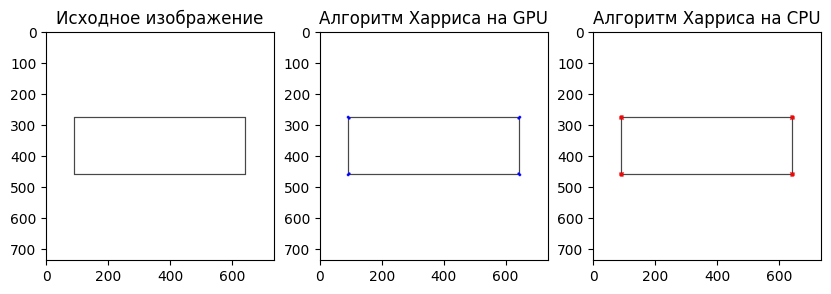

In [ ]:
import matplotlib.pyplot as plt

# Визуализация результатов
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Исходное изображение")
plt.imshow(input_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Алгоритм Харриса на GPU")
plt.imshow(output_image_gpu, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Алгоритм Харриса на CPU")
plt.imshow(output_image_cpu, cmap='gray')
plt.show()

In [ ]:
cv2.imwrite('output_image_cpu.bmp', output_image_cpu)
cv2.imwrite('output_image_gpu.bmp', output_image_gpu)

True

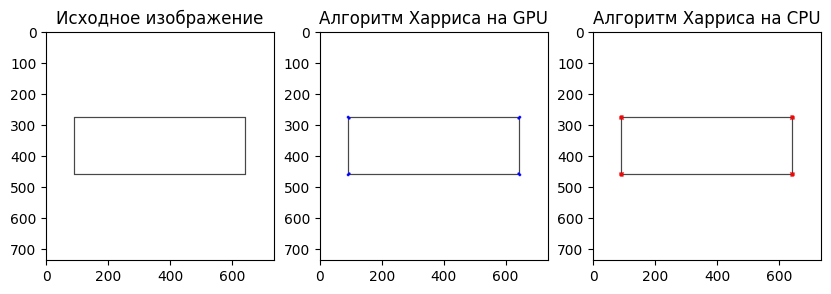

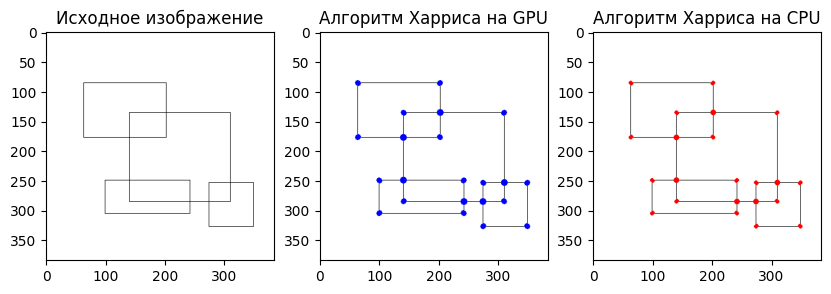

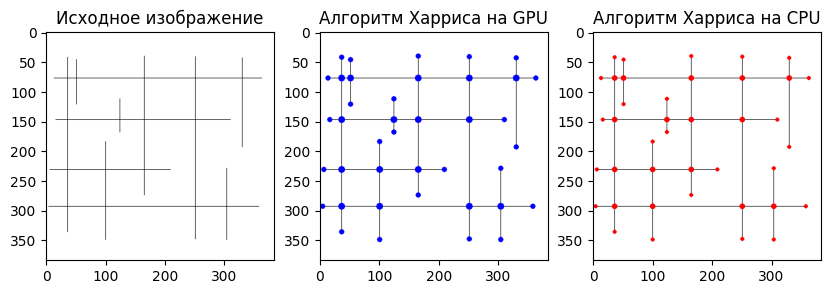

In [ ]:
# Проверка для 5 изображений
image_paths = [f'input_{i}.bmp' for i in range(3)]

total_time_gpu = 0
total_time_cpu = 0
total_acceleration = 0

for idx, image_path in enumerate(image_paths):
    input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if input_image is None:
        raise ValueError(f"Изображение {image_path} не загружено. Проверьте путь.")

    output_image_gpu, time_gpu = harris_corners_gpu(input_image, k, window_size, threshold)
    total_time_gpu += time_gpu

    output_image_cpu, time_cpu = harris_corners_cpu(input_image, k, window_size, threshold)
    total_time_cpu += time_cpu

    acceleration = time_cpu / time_gpu
    total_acceleration += acceleration

    # Визуализация результатов
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Исходное изображение")
    plt.imshow(input_image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Алгоритм Харриса на GPU")
    plt.imshow(output_image_gpu, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Алгоритм Харриса на CPU")
    plt.imshow(output_image_cpu, cmap='gray')
    plt.show()

In [ ]:
# Вычисление среднего времени выполнения и ускорения
print(f"Среднее время выполнения на GPU: {total_time_gpu / len(image_paths):.4f} сек")
print(f"Среднее время выполнения на CPU: {total_time_cpu / len(image_paths):.4f} сек")
print(f"Среднее ускорение: {total_acceleration / len(image_paths):.4f}")

Среднее время выполнения на GPU: 0.0098 сек
Среднее время выполнения на CPU: 2.0765 сек
Среднее ускорение: 206.7563
